# Pi on the CPU (python) and the GPU (python+pycuda/CUDA C++)

Minimal working example for (not so clever) calculation of $\pi$ on the CPU using python, and on the GPU using python+pycuda on the host and CUDA C++ on the GPU device.

## Setup on GPU PPI-node for using Jupyter notebook + pycuda + CUDA


```
Upgrade pip, use your local (now upgraded) pip, and force download of and installation/compilation of pycuda:
> pip3 install --user --upgrade pip
> export PATH=$HOME/.local/bin:$PATH
> export PATH=$PATH:/usr/local/cuda-10.0/bin/
> pip3 install --user --no-cache --upgrade pycuda
WARNING: Your user directory on Lustre is mounted on several servers. 
         To use a different GPU (on a different server), pycuda must be recompiled!

Start notebook server on PPI (in the background) and follow the given link in a local browser:
> jupyter notebook --no-browser --ip=$(hostname -f) &


To shutdown notebook server (assuming you only have one job running in the background):
> fg
> (CTRL+C)(CTRL+C)
```

## Resources

* Jupyter notebook install instructions: https://jupyter.org/install
* Jupyter notebook demos: https://jupyter.org/try
* pycuda documentation: https://documen.tician.de/pycuda/

## Python in cells

In [1]:
print("hello")

hello


In [15]:
a=2
b=5
c=a+b
print(c)

7


## Unit Circle

In [3]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

In [4]:
x = np.linspace(-1,1,50)
y1 = np.sqrt(1-x**2)
y2 = -y1

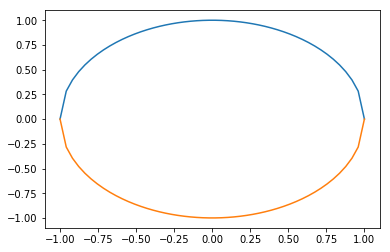

In [5]:
plt.plot(x,y1)
plt.plot(x,y2)

## Compute $\pi$

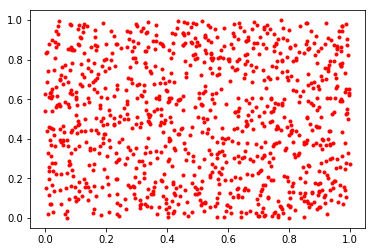

In [6]:
n = 1000

x = np.random.random(n)
y = np.random.random(n)

plt.plot(x, y, 'r.')

In [7]:
r = np.sqrt(x**2 + y**2)

In [8]:
inside = np.where(r <= 1, True, False)
outside = ~inside

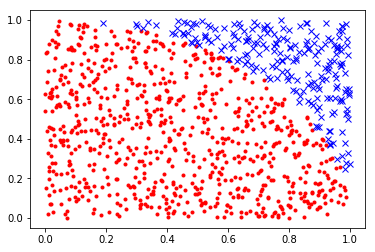

In [9]:
plt.plot(x[inside], y[inside], 'r.')
plt.plot(x[outside], y[outside], 'bx')

In [10]:
num_inside = np.sum(inside)

A = num_inside / n
pi = 4*A
print(pi)

3.128


## CUDA

![CUDA grid](cuda_grid.png)

In [13]:
import pycuda.autoinit
import pycuda.driver as cuda
import numpy

from pycuda.compiler import SourceModule

mod = SourceModule("""
__global__ void cudaPI(float* dest) {
    // find global index of thread in x- and y-dimension
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    
    // linearized (1D) global index of thread
    int idx = i + j*(gridDim.x * blockDim.x);
    
    // compute distance between threads
    // (each thread representing one point placed on the 1st "unit circle quadrant", see image above)
    float dx = 1.0f / (float) (gridDim.x * blockDim.x);
    float dy = 1.0f / (float) (gridDim.y * blockDim.y);
    
    // compute x- and y-coordinates between 0.0 and 1.0
    float x = i*dx;
    float y = j*dy;
    
    // is the point inside the unit circle or not?
    int inside = 0;
    if (x * x + y * y < 1.0f) {
        // point is inside circle!
        ++inside;
    }
    dest[idx] = inside;
}
""")


cudaPI = mod.get_function("cudaPI")

grid = (100, 100)
block = (10, 10, 1)


nx = grid[0]*block[0]
ny = grid[1]*block[1]

results = numpy.zeros(nx*ny).astype(numpy.float32)

cudaPI(cuda.Out(results),
        block=block, grid=grid)

# sum up results from each CUDA-thread
k = 0.0;
for i in range(0,len(results)):
    k += results[i];

# calculate final result
n = nx*ny
pi = 4 * (k / n)

print(n)
print(k)
print("PI is (approximately): " + str(pi))

1000000
786380.0
PI is (approximately): 3.14552
